# Alpaca Trading Workbook

### Data Scraper

In [6]:
# data & API packages
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame, TimeFrameUnit
import sqlite3
import pandas as pd
import time
import random
import ta
from datetime import datetime, timedelta
#modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

class AlpacaTradingBot:
    """

    This class can be used to scrape stock data from the Alpaca API, store it locally in a SQLite Database,
    add indicators & perform predective analytics.

    """
    def __init__(self, keys_file_path='alpaca_keys.txt', base_url='https://paper-api.alpaca.markets', database_path=r'D:\Scripts\alpaca\alpaca_algo_trading\alpaca_data.db'):
        with open(keys_file_path, 'r') as file:
            self.api_key = file.readline().strip()
            self.api_secret = file.readline().strip()
        self.base_url = base_url
        self.api = tradeapi.REST(self.api_key, self.api_secret, base_url=base_url)
        self.database_path = database_path
        self.api_call_count = 0

    def download_bar_data(self, stock, timeframe, start_date, end_date):
        """
        
        This method will be used to scrape bar data from the Alpaca API. 
        Provide a ticker symbol, an interval, and a beginning and end date.

        """
        all_data = []

        current_date = start_date
        while current_date <= end_date:
            # Check if it's a weekend (Saturday or Sunday) & skip, if so
            # if  datetime.strptime(current_date, "%Y-%m-%d").weekday() >= 5:
            #     current_date = (datetime.strptime(current_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
            #     continue

            # Split the day into two segments: midnight to noon, and noon to end of day because the API can only return 1,000 data points a day
            segments = [
                (f"{current_date}T00:00:00Z", f"{current_date}T11:59:59Z"),
                (f"{current_date}T12:00:00Z", f"{current_date}T23:59:59Z")
            ]

            for start_time, end_time in segments:
                try:
                    # Get data for the current day segment
                    bars = self.api.get_bars(stock, timeframe, start=start_time, end=end_time, limit=1000).df
                    self.api_call_count += 1  # Increment the API call counter
                    if not bars.empty:
                        bars['symbol'] = stock  # Add the stock symbol column
                        all_data.append(bars)
                        print(f"Data scraped for {current_date} through {end_time.split('T')[1]}...")
                    else:
                        print(f"No data available for segment: {current_date}: {start_time.split('T')[1]} - {end_time.split('T')[1]}")
                except tradeapi.rest.APIError as e:
                    print(f"API Error: {e}")
                    pause_duration = random.uniform(120, 240)  # Longer pause if an API error occurs
                    time.sleep(pause_duration)
                    continue
                
            # Random pause after each scrape.. API rate limits need to be considered. Only a problem for the main original pull to populate the database.
            if (datetime.strptime(current_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days % 1 == 0:
                print(f"Total API calls made so far: {self.api_call_count}")
                pause_duration = random.uniform(10, 30)
                print(f"Pausing for {pause_duration} after scraping data for {current_date}...")
                print(f"__________________________________")
                time.sleep(pause_duration)

            # Move to the next day
            current_date = (datetime.strptime(current_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")

        if all_data:
            combined_data = pd.concat(all_data)
            combined_data = combined_data.reset_index()  # Ensure the index is reset to have 'timestamp' as a column
            print("Scraping Bar Data complete for timerange:", combined_data['timestamp'].min(), " - ", combined_data['timestamp'].max())
            return combined_data[['symbol'] + [col for col in combined_data.columns if col not in ['symbol']]]
        else:
            return pd.DataFrame()
        
    def calculate_indicators_modeling(self, stock_data):
        """
        This method calculates various indicators on a dataframe tailored for a 1-hour trading strategy.
        """

        # Trend Indicators
        stock_data['sma_30'] = ta.trend.sma_indicator(stock_data['CLOSE'], window=30)
        # 30-minute SMA (Simple Moving Average) for medium-term trend analysis

        stock_data['ema_30'] = ta.trend.ema_indicator(stock_data['CLOSE'], window=30)
        # 30-minute EMA for a responsive short to medium-term trend

        stock_data['macd'] = ta.trend.macd(stock_data['CLOSE'], window_slow=26, window_fast=12)
        stock_data['macd_signal'] = ta.trend.macd_signal(stock_data['CLOSE'], window_slow=26, window_fast=12, window_sign=9)
        # Standard MACD (Moving Average Convergence Divergence) settings for capturing trend and momentum changes

        # Momentum Indicators
        stock_data['rsi'] = ta.momentum.rsi(stock_data['CLOSE'], window=14)
        # 14-minute RSI (Relative Strength Index) for overbought/oversold conditions

        stock_data['stochastic_k'] = ta.momentum.stoch(stock_data['HIGH'], stock_data['LOW'], stock_data['CLOSE'], window=14, smooth_window=3)
        # 14-minute Stochastic Oscillator for short-term momentum

        stock_data['cci'] = ta.trend.cci(stock_data['HIGH'], stock_data['LOW'], stock_data['CLOSE'], window=20)
        # 20-minute CCI for identifying cyclical trends

        # Volatility Indicators
        bb_indicator = ta.volatility.BollingerBands(stock_data['CLOSE'], window=20, window_dev=2)
        stock_data['bollinger_hband'] = bb_indicator.bollinger_hband()
        stock_data['bollinger_lband'] = bb_indicator.bollinger_lband()
        stock_data['bollinger_mband'] = bb_indicator.bollinger_mavg()
        stock_data['bollinger_width_percent'] = (stock_data['bollinger_hband'] - stock_data['bollinger_lband']) / stock_data['CLOSE']
        stock_data['bollinger_position'] = bb_indicator.bollinger_pband()
        # Bollinger Bands with standard deviation score for precise volatility measure

        stock_data['atr'] = ta.volatility.average_true_range(stock_data['HIGH'], stock_data['LOW'], stock_data['CLOSE'], window=14)
        # 14-minute ATR (Average True Range) for short-term volatility

        # Volume-Based Indicators
        stock_data['obv'] = ta.volume.on_balance_volume(stock_data['CLOSE'], stock_data['VOLUME'])
        # OBV (On-Balance Volume) for volume-based trend prediction

        # Calculate VWAP for each day
        stock_data['vwap'] = stock_data.groupby(stock_data['timestamp_est'].dt.date).apply(
            lambda x: (x['CLOSE'] * x['VOLUME']).cumsum() / x['VOLUME'].cumsum()
        ).reset_index(level=0, drop=True)

        return stock_data

    def transfer_stage_modeling(self, input_table, symbol, output_table):
        """
        
        This method cleans the scraped raw stage data, adds indicator calculations on it inserts the otuput into a fresh table.

        """
        db_path = self.database_path
        conn = sqlite3.connect(db_path)

        try:

            # Read the entire table
            input_data = pd.read_sql(f"SELECT distinct * FROM {input_table} WHERE SYMBOL = '{symbol}'" , conn)

            # Check if the input data is empty
            if input_data.empty:
                raise ValueError(f"No data found for symbol {symbol} in table {input_table}")

            # Convert 'TIMESTAMP' to datetime and localize it to UTC
            input_data['timestamp_utc'] = pd.to_datetime(input_data['TIMESTAMP'], utc=True)
            input_data['timestamp_est'] = input_data['timestamp_utc'].dt.tz_convert('US/Eastern')
            input_data['trading_hours_ind'] = (input_data['timestamp_est'].dt.time >= datetime.strptime('09:30', '%H:%M').time()) & \
                                            (input_data['timestamp_est'].dt.time <= datetime.strptime('16:00', '%H:%M').time())
            input_data['trading_hours_ind_ext'] = (input_data['timestamp_est'].dt.time >= datetime.strptime('10:30', '%H:%M').time()) & \
                                                    (input_data['timestamp_est'].dt.time <= datetime.strptime('15:00', '%H:%M').time())

            # Calculate indicators
            indicators_data = self.calculate_indicators_modeling(input_data)

            # Calculate additional features
            indicators_data['date'] = indicators_data['timestamp_est'].dt.date
            indicators_data['day_of_week'] = indicators_data['timestamp_est'].dt.dayofweek
            indicators_data['hour_of_day'] = indicators_data['timestamp_est'].dt.hour
            indicators_data['time_of_day'] = indicators_data['timestamp_est'].dt.time

            # Movement in-day & in-week as percentage
            indicators_data['daily_opening_price'] = indicators_data.groupby(indicators_data['timestamp_est'].dt.date)['OPEN'].transform('first')
            indicators_data['daily_movement_since_open'] = (indicators_data['CLOSE'] - indicators_data['daily_opening_price']) / indicators_data['daily_opening_price']

            indicators_data['weekly_opening_price'] = indicators_data.groupby(indicators_data['timestamp_est'].dt.isocalendar().week)['OPEN'].transform('first')
            indicators_data['weekly_movement_since_open'] = (indicators_data['CLOSE'] - indicators_data['weekly_opening_price']) / indicators_data['weekly_opening_price']

            # Calculate percentage movement over the last 20 periods (20 minutes)
            indicators_data['pct_movement_20_periods'] = indicators_data['CLOSE'].pct_change(periods=20)

            # Calculate percentage movement over the last 60 periods (1 hour)
            indicators_data['pct_movement_60_periods'] = indicators_data['CLOSE'].pct_change(periods=60)

            # Targets
            indicators_data['target_1_hour'] = indicators_data['CLOSE'].shift(-60)
            # Target for the closing price 1 hour from the current time, aligning with the 1-hour trading strategy
            # Calculate movement_pct and signal
            indicators_data['target_movement_pct'] = ((indicators_data['target_1_hour'] - indicators_data['CLOSE']).abs() / indicators_data['CLOSE']) * 100
            indicators_data['target_movement_signal'] = indicators_data.apply(
                lambda row: 1 if (row['target_1_hour'] - row['CLOSE']) > 0.001 * row['CLOSE'] else 
                            (-1 if (row['target_1_hour'] - row['CLOSE']) <= -0.001 * row['CLOSE'] else 0), 
                axis=1
            )

            # Drop some columns and reorder
            indicators_data = indicators_data.drop(columns=['TIMESTAMP', 'timestamp_utc'])
            indicators_data = indicators_data[['SYMBOL', 'timestamp_est', 'date', 'trading_hours_ind', 'trading_hours_ind_ext'] + [col for col in indicators_data.columns if col not in ['SYMBOL', 'timestamp_est', 'date', 'trading_hours_ind', 'trading_hours_ind_ext']]]

            # Upload data to output table
            self.db_append(output_table, indicators_data)

        except Exception as e:
            print(f"Error processing symbol {symbol}: {e}")
    
        finally:
            conn.close()

        return indicators_data

    def db_write(self, sql_statement):
        """

        Basic functionality to execute an SQL statement against our database

        """
        db_path = self.database_path

        # Connect to the database & create a cursor object
        conn = sqlite3.connect(db_path)
        cur = conn.cursor()

        # Execute the SQL statement
        cur.execute(sql_statement)

        # Commit the changes & close the connection
        conn.commit()
        conn.close()

    def db_append(self, table_name, data_frame):
        """

        Basic functionality to append/insert a dataframe into a specified table in our database

        """
        db_path = self.database_path

        # Connect to the database
        conn = sqlite3.connect(db_path)

        # Append our dataframe into our table
        data_frame.to_sql(table_name, conn, schema='main', if_exists='append', index=False)

        # Commit the changes & close the connection
        conn.commit()
        conn.close()
        
    def db_append_no_duplicates(self, table_name, data_frame):
        """

        Variation of db_append that makes sure we aren't inserting duplicates by first checking against the primary key of the table records are being inserted into

        """
        db_path = self.database_path

        # Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # Get the primary key column names
        cursor.execute(f"PRAGMA table_info({table_name})")
        table_info = cursor.fetchall()
        primary_key_columns = [column[1] for column in table_info if column[5] == 1]

        # If no primary key columns found, fall back to db_append method
        if not primary_key_columns:
            data_frame.to_sql(table_name, conn, schema='main', if_exists='append', index=False)

            # Commit the changes & close the connection
            conn.commit()
            conn.close()
            return

        # Construct the SELECT statement to fetch existing primary keys from the table
        existing_keys_query = f"SELECT {', '.join(primary_key_columns)} FROM {table_name}"
        existing_keys_df = pd.read_sql(existing_keys_query, conn)

        # Construct the composite primary key from the existing keys DataFrame
        existing_keys_df['COMPOSITE_KEY'] = existing_keys_df.apply(lambda row: tuple(row), axis=1)
        existing_keys = set(existing_keys_df['COMPOSITE_KEY'])

        # Construct the composite primary key for new records
        data_frame['COMPOSITE_KEY'] = data_frame.apply(lambda row: tuple(row[primary_key_columns]), axis=1)

        # Filter out rows with primary keys that already exist in the table
        data_frame_new_records = data_frame[~data_frame['COMPOSITE_KEY'].isin(existing_keys)]

        # Drop the composite key column
        data_frame_new_records = data_frame_new_records.drop(columns=['COMPOSITE_KEY'])

        # Append only the new rows into our table
        data_frame_new_records.to_sql(table_name, conn, schema='main', if_exists='append', index=False)

        # Commit the changes & close the connection
        conn.commit()
        conn.close()

    def classification_modeling(self, features, target, symbol):
        """
        Splits the data into training and testing sets based on provided features and target variable for a specific symbol.
        """
        conn = sqlite3.connect(self.database_path)
        df = pd.read_sql(f"SELECT * FROM SYMBOL_DATA_MODELING WHERE SYMBOL = '{symbol}' AND TRADING_HOURS_IND_EXT = 1", conn)
        conn.close()

        X = df[features]
        y = df[target]

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

        models = {
            "Logistic Regression": LogisticRegression(),
            "Random Forest": RandomForestClassifier(),
            "Support Vector Machine": SVC(),
            "Gradient Boosting": GradientBoostingClassifier(),
            "K-Nearest Neighbors": KNeighborsClassifier(),
            "XGBoost": XGBClassifier(),
            "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=42)
        }

        for model_name, model in models.items():
            print(f"Processing {model_name} for symbol: {symbol}")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            f1 = f1_score(y_val, y_pred, average='weighted')
            cm = confusion_matrix(y_val, y_pred)
            cr = classification_report(y_val, y_pred)

            # visualize & print results
            print(f"{model_name} - F1 Score: {f1}")
            print("Confusion Matrix:\n", cm)
            print("Classification Report:\n", cr)
            sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d')
            plt.title(f'Confusion Matrix: {model_name}')
            plt.show()
            print(f"__________________________________")
            # Save the model
            joblib.dump(model, f'{symbol}_{model_name}.pkl')

            evaluation_results = {
                'SYMBOL': symbol,
                'MODEL_NAME': model_name,
                'F1_SCORE': f1,
                'CONFUSION_MATRIX': str(cm),
                'CLASSIFICATION_REPORT': cr
            }
            results_df = pd.DataFrame([evaluation_results])
            self.db_append('CLASSIFICATION_MODEL_RESULTS', results_df)

### Schema DDL

In [3]:
"""

Schema DDL - creates the tables in our database that we need for storing the raw scraped data & analyzing it.

"""
atb = AlpacaTradingBot()

# This table will house the raw scraped data
# sql_statement = atb.db_write('''DROP TABLE IF EXISTS STG_SYMBOL_DATA''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS STG_SYMBOL_DATA (
#     SYMBOL                  TEXT        PRIMARY_KEY,
#     TIMESTAMP               TIMESTAMP   PRIMARY_KEY,
#     CLOSE                   DECIMAL,
#     HIGH                    DECIMAL,
#     LOW                     DECIMAL,
#     TRADE_COUNT             INTEGER,
#     OPEN                    DECIMAL,
#     VOLUME                  INTEGER,
#     VWAP                    DECIMAL

# )
# ''')

# sql_statement = atb.db_write('''DROP TABLE IF EXISTS SYMBOL_DATA_MODELING''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS SYMBOL_DATA_MODELING (
#     SYMBOL                      TEXT            PRIMARY_KEY,
#     TIMESTAMP_EST               TIMESTAMP       PRIMARY_KEY,
#     DATE                        DATE,
#     TRADING_HOURS_IND           BOOLEAN,
#     TRADING_HOURS_IND_EXT       BOOLEAN,
#     CLOSE                       DECIMAL,
#     HIGH                        DECIMAL,
#     LOW                         DECIMAL,
#     TRADE_COUNT                 INTEGER,
#     OPEN                        DECIMAL,
#     VOLUME                      INTEGER,
#     VWAP                        DECIMAL,
#     RSI                         DECIMAL,
#     SMA_30                      DECIMAL,
#     EMA_30                      DECIMAL,
#     MACD                        DECIMAL,
#     MACD_SIGNAL                 DECIMAL,
#     STOCHASTIC_K                DECIMAL,
#     CCI                         DECIMAL,
#     BOLLINGER_HBAND             DECIMAL,
#     BOLLINGER_LBAND             DECIMAL,
#     BOLLINGER_MBAND             DECIMAL,
#     BOLLINGER_WIDTH_PERCENT     DECIMAL,
#     BOLLINGER_POSITION          DECIMAL,
#     ATR                         DECIMAL,
#     OBV                         INTEGER,
#     TARGET_1_HOUR               DECIMAL,
#     TARGET_MOVEMENT_PCT         DECIMAL,        
#     TARGET_MOVEMENT_SIGNAL      INTEGER,
#     DAY_OF_WEEK                 INTEGER,
#     HOUR_OF_DAY                 INTEGER,
#     TIME_OF_DAY                 TIME,
#     DAILY_OPENING_PRICE         DECIMAL,
#     DAILY_MOVEMENT_SINCE_OPEN   DECIMAL,
#     WEEKLY_OPENING_PRICE        DECIMAL,
#     WEEKLY_MOVEMENT_SINCE_OPEN  DECIMAL,
#     PCT_MOVEMENT_20_PERIODS     DECIMAL,
#     PCT_MOVEMENT_60_PERIODS     DECIMAL

# )
# ''')

# sql_statement = atb.db_write('''DROP TABLE IF EXISTS MODEL_EVALUATION_RESULTS ''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS CLASSIFICATION_MODEL_RESULTS  (
#     ID                      INTEGER PRIMARY KEY AUTOINCREMENT,
#     SYMBOL                  TEXT NOT NULL,
#     MODEL_NAME              TEXT NOT NULL,
#     F1_SCORE                REAL NOT NULL,
#     CONFUSION_MATRIX        TEXT NOT NULL,
#     CLASSIFICATION_REPORT   TEXT NOT NULL,
#     EVALUATION_TIMESTAMP    DATETIME DEFAULT CURRENT_TIMESTAMP

# )
# ''')



### Populate Historical Data to Stage & Prepare for Modeling

In [65]:
"""

Query & store historical data in out stage table. Only need to run this on the first run.

"""
atb = AlpacaTradingBot()

# Define the list of stocks
stocks = ["SPY"]

# Define the time range for historical data
start_date = "2020-01-01"
# end_date = "2020-01-02"
end_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")

# Step 1: Download and store historical data in the staging table
data = {}
for stock in stocks:
    # Download historical data
    stock_data = atb.download_bar_data(stock, TimeFrame(1, TimeFrameUnit.Minute), start_date, end_date)
    data[stock] = stock_data

# Store all downloaded data in the staging table
for stock, stock_data in data.items():
    atb.db_append('STG_SYMBOL_DATA', stock_data)

# Step 2: Transfer data from the staging table to the modeling table
for stock in stocks:
    atb.transfer_stage_modeling('STG_SYMBOL_DATA', stock, 'SYMBOL_DATA_MODELING')

Data scraped for 2020-01-01 through 11:59:59Z...
No data available for segment: 2020-01-01: 12:00:00Z - 23:59:59Z
Total API calls made so far: 2
Pausing for 25.486324505116688 after scraping data for 2020-01-01...
__________________________________
Data scraped for 2020-01-02 through 11:59:59Z...
Data scraped for 2020-01-02 through 23:59:59Z...
Total API calls made so far: 4
Pausing for 26.843622440158285 after scraping data for 2020-01-02...
__________________________________
Data scraped for 2020-01-03 through 11:59:59Z...
Data scraped for 2020-01-03 through 23:59:59Z...
Total API calls made so far: 6
Pausing for 11.18019651783725 after scraping data for 2020-01-03...
__________________________________
No data available for segment: 2020-01-04: 00:00:00Z - 11:59:59Z
No data available for segment: 2020-01-04: 12:00:00Z - 23:59:59Z
Total API calls made so far: 8
Pausing for 19.781400727702277 after scraping data for 2020-01-04...
__________________________________
No data available for

###  Classification Modeling

Processing symbol: SPY
Processing Logistic Regression for symbol: SPY


d:\Scripts\alpaca\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scripts\alpaca\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scripts\alpaca\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression - F1 Score: 0.24035803890809687
Confusion Matrix:
 [[ 1504 24268     0]
 [  508 33651     0]
 [ 1660 28613     0]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.41      0.06      0.10     25772
           0       0.39      0.99      0.56     34159
           1       0.00      0.00      0.00     30273

    accuracy                           0.39     90204
   macro avg       0.27      0.35      0.22     90204
weighted avg       0.26      0.39      0.24     90204



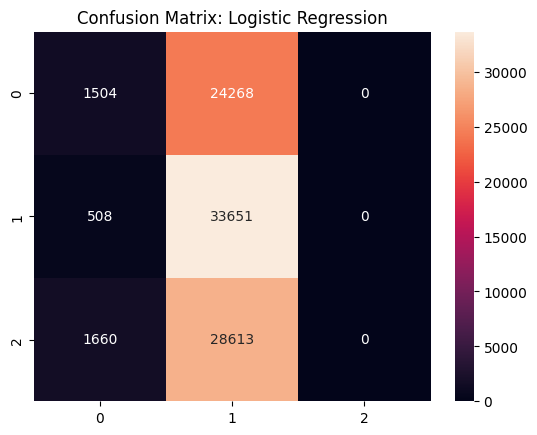

__________________________________
Processing Random Forest for symbol: SPY
Random Forest - F1 Score: 0.887568935078547
Confusion Matrix:
 [[22937  2521   314]
 [ 1910 29819  2430]
 [  152  2837 27284]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.92      0.89      0.90     25772
           0       0.85      0.87      0.86     34159
           1       0.91      0.90      0.90     30273

    accuracy                           0.89     90204
   macro avg       0.89      0.89      0.89     90204
weighted avg       0.89      0.89      0.89     90204



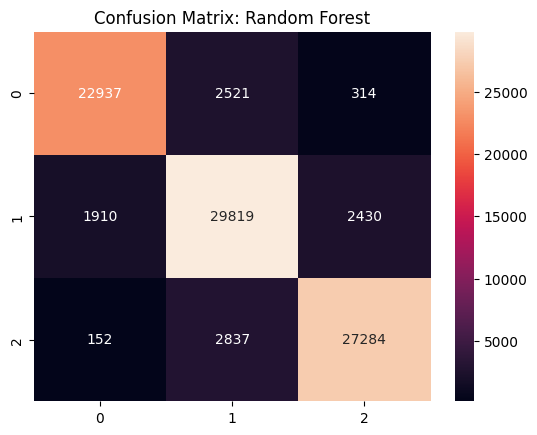

__________________________________
Processing Support Vector Machine for symbol: SPY


In [7]:
# Instantiate and use the trading bot
atb = AlpacaTradingBot()

# Select features, target, and symbol to run our classifaction models on 
symbols = ['SPY']
target = 'TARGET_MOVEMENT_SIGNAL'
features = ['MACD', 'MACD_SIGNAL', 'RSI', 'STOCHASTIC_K', 'CCI', 'BOLLINGER_WIDTH_PERCENT',
            'BOLLINGER_POSITION', 'ATR', 'OBV', 'DAILY_MOVEMENT_SINCE_OPEN', 'WEEKLY_MOVEMENT_SINCE_OPEN',
            'PCT_MOVEMENT_20_PERIODS', 'PCT_MOVEMENT_60_PERIODS', 'DAY_OF_WEEK', 'HOUR_OF_DAY']

# Run models for each symbol
for symbol in symbols:
    print(f"Processing symbol: {symbol}")
    atb.classification_modeling(features, target, symbol)
    print(f"Completed processing for symbol: {symbol}\n")